In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp
import json

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})

np.set_printoptions(threshold=sys.maxsize)

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [2]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence

# State tomography analysis functions

Measurement occurs along 9 axes, each of which can give one of 4 values:

ZZ, ZX, ZY, XZ, XX, XY, YZ, YX, YY -> {00, 01, 10, 11}

In [3]:
meas_order = np.array(['ZZ', 'ZX', 'ZY', 'XZ', 'XX', 'XY', 'YZ', 'YX', 'YY'])
calib_order = np.array(['gg', 'ge', 'eg', 'ee'])

## Getting rho from meas counts

First random helper method stuff for pauli matrices and dealing with the measurement order

In [4]:
def pauli(i): return [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()][i]

def s2i(s): # string to pauli matrix index
    return int(np.char.find('IXYZ', s))

def i2s(i): # pauli matrix index to string
    return 'IXYZ'[i]

def order(S12): # given 2 pauli matrix names, get the index at which that combo (or equivalent data) was measured
    assert S12[0] in 'IXYZ'
    assert S12[1] in 'IXYZ'
    # for the purposes of getting counts, measuring in I basis and Z basis are interchangeable
    if S12[0] == 'I': S12 = 'Z'+S12[1]
    if S12[1] == 'I': S12 = S12[0]+'Z'
    return np.argwhere(meas_order == S12)[0][0]
# print(order('II'))

In [197]:
"""
Define basis in to be used when doing MLE
"""
# 2 cardinal points on Bloch sphere for each measurement axis
# psiZ = [qt.basis(3,0), qt.basis(3,1)]
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi = dict(Z=psiZ, X=psiX, Y=psiY)

psi_basis = [] # ordered in the same sequence as the n counts array (36 elements)
psi_tensor = [psiZ[0], psiZ[0], psiZ[0], psiZ[0]]
for S12 in meas_order:
    S1, S2 = S12
    psi1 = psi[S1]
    psi2 = psi[S2]

    psi_basis.append(qt.tensor(psi1[0], psi2[0])) # gg
    psi_basis.append(qt.tensor(psi1[0], psi2[1])) # ge
    psi_basis.append(qt.tensor(psi1[1], psi2[0])) # eg
    psi_basis.append(qt.tensor(psi1[1], psi2[1])) # ee

# def get_psi_basis(qubits):
#     q0, q1 = qubits

#     for S12 in meas_order:
#         S1, S2 = S12
#         psi1 = psi[S1]
#         psi2 = psi[S2]

#         # gg
#         psi_tensor[q0] = psi1[0]
#         psi_tensor[q1] = psi2[0]
#         psi_basis.append(qt.tensor(*psi_tensor))

#         # ge
#         psi_tensor[q0] = psi1[0]
#         psi_tensor[q1] = psi2[1]
#         psi_basis.append(qt.tensor(*psi_tensor)) # ge

#         # eg 
#         psi_tensor[q0] = psi1[1]
#         psi_tensor[q1] = psi2[0]
#         psi_basis.append(qt.tensor(*psi_tensor)) # eg

#         # ee
#         psi_tensor[q0] = psi1[1]
#         psi_tensor[q1] = psi2[1]
#         psi_basis.append(qt.tensor(*psi_tensor)) # ee

#     return psi_basis

Convert single shot measurements into counts for each of the 9 measurement axes: 4x9=36 elements in the count array, then into the initial rho from experiment which will likely be unphysical.

In [6]:
"""
n should be length 4 array containing single shot counts of measuring 00, 01, 10, 11 for measurement along axes i, j
Converts n to Tij for use in the T^\dag T = rho matrix where measurement axes are S1 and S2: I, X, Y, Z
"""
def Tij(n, S1, S2):
    assert 0 <= S1 <= 3 # S1, S2 represent pauli matrix indices
    assert 0 <= S2 <= 3
    signs = [1]*4
    # eigenvalues of X, Y, Z are +/- 1, eigenvalues of I are +1
    if S1 > 0: signs[2] *= -1; signs[3] *= -1
    if S2 > 0: signs[1] *= -1; signs[3] *= -1
    return np.sum(np.multiply(signs, n))


In [187]:
a = qt.destroy(2)
h0 = (5*a.dag()*a)
evals = h0.eigenenergies()
print(evals - evals[0])

h1 = (5/2*qt.tensor(qt.sigmaz(), qt.qeye(2)) + 8/2*qt.tensor(qt.sigmaz(), qt.qeye(2)))
print(h1.full())
evals = h1.eigenenergies()
print(evals - evals[0])

h2 = (5/2*qt.tensor(qt.sigmaz(), qt.qeye(2)) + 8/2*qt.tensor(qt.sigmaz(), qt.qeye(2)) + 1/2*qt.tensor(qt.sigmaz(), qt.sigmaz()))
print(h2.full())
evals = h2.eigenenergies()
print(evals - evals[0])


[0. 5.]
[[ 6.5+0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  6.5+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j -6.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -6.5+0.j]]
[ 0.  0. 13. 13.]
[[ 7.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  6.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -7.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -6.+0.j]]
[ 0.  1. 13. 14.]


In [181]:
(a.dag()*a.dag()*a*a).full()

array([[0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])

In [205]:
"""
Construct rho by adding together Tij for each of the 4^2 = 16 combinations of tensor product of 2 Pauli matrices
"""
def rho_from_counts(n):
    rho = 0*qt.tensor(qt.qeye(2), qt.qeye(2))
    for i in range(4): # loop over pauli matrices for qubit 1
        for j in range(4): # loop over pauli matrices for qubit 2
            o = order(i2s(i) + i2s(j)) # get the right 4 elements in the n matrix
            # print(i2s(i), i2s(j), Tij(n[4*o:4*(o+1)], i, j))
            rho += Tij(n[4*o:4*(o+1)], i, j) * qt.tensor(pauli(i), pauli(j))
    rho = rho.unit() # normalize
    rho = rho.tidyup(1e-10) # remove small elements
    rho = rho.full()

    # # expand rho into a 4 qubit subspace
    # q0, q1 = qubits
    # if q0 > q1: rho = qt.qip.gates.swap(N=4, targets=qubits).full() @ rho
    # id = qt.qeye(2)
    # tensor = [id, id, id]
    # tensor[min((q0, q1))] = rho
    # rho = qt.tensor(*tensor)
    # if max((q0, q1)) - min((q0, q1)) > 1:
    #     rho = qt.qip.gates.swap(N=4, targets=[min((q0, q1)) + 1, max((q0, q1))])

    return rho

### Generate test data

In [388]:
def generate_counts(qubits, rho_id, n_tot, noise=1.0):
    n = []
    # psi_basis = get_psi_basis(qubits)
    for psi in psi_basis:
        # measure in psi basis
        n.append(n_tot * (psi * psi.dag() * rho_id).tr())
    n = np.reshape(np.array(n), (len(psi_basis)//4, 4))

    # introduce gaussian noise
    for n_psi in n:
        n_meas = sum(n_psi)
        new_n3 = -1
        while new_n3 < 0:
            new_n012 = np.random.normal(loc=n_psi[:3], scale=noise*np.sqrt(n_psi[:3]))
            # preserve original total count per measurement
            new_n3 = n_meas - sum(new_n012)
        n_psi[:3] = np.round(new_n012)
        n_psi[3] = np.round(new_n3)
    return n

### Error mitigation
Readout error means state prepared in |gg> will also have counts in |ge>, |eg>, |ee>; apply inverse of confusion matrix to correct. See qiskit measurement error mitigation procedure: [https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html)

maybe need to do something about fixing negative counts, but for now I will not. it should be automatically resolved in the MLE.

In [9]:
def correct_readout_err(n, n_conf):
    conf_mat = np.array(n_conf, dtype=float)
    for r, row in enumerate(conf_mat):
        conf_mat[r] /= sum(row) # normalize so counts for each state prep sum to 1
    conf_mat = np.transpose(conf_mat) # want counts for each state prep on columns
    conf_mat_inv = np.linalg.inv(conf_mat)
    # C_id = invM . C_noisy
    n = np.array(n, dtype=float)
    for r in range(len(n)):
        n[r] = (conf_mat_inv @ n[r].T).T
    return np.around(n, decimals=5)

## Fix rho to a physical density matrix using MLE
Initial counts will be unphysical. Use MLE to map counts to a physical density matrix.

### Cholesky-esque decomposition functions

In [10]:
# Modification of np.diag_indices to allow off diagonal entries
# n = dim, k < 0 = lower diagonals, k > 0 = upper diagonals
def diag_indices_k(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0: return rows[-k:], cols[:k]
    elif k > 0: return rows[:-k], cols[k:]
    else: return rows, cols

def T_flat2mat(t):
    # T_mat = []
    # T_mat.appen(np.array([t[0],           0,              0,               0]))
    # T_mat.append(np.array([t[4] +1j*t[5],  t[1],           0,               0]))
    # T_mat.append(np.array([t[10]+1j*t[11], t[6]+1j*t[7],   t[2],            0]))
    # T_mat.append(np.array([t[14]+1j*t[15], t[12]+1j*t[13], t[8]+1j*t[9], t[3]]))
    d = int(np.sqrt(len(t)))
    t_complex = np.zeros(int(d + (len(t)-d)/2), dtype=complex)
    t_complex[:d] = t[:d]
    for i in range(d, len(t_complex)):
        t_complex[i] = t[d + (i-d)*2] + 1j*t[d + (i-d)*2 + 1]
    T_mat = np.zeros(shape=(d,d), dtype=complex)
    start_i = 0
    for k in range(d):
        T_mat[diag_indices_k(T_mat, -k)] = t_complex[start_i:start_i+(d-k)]
        start_i += d - k
    return np.array(T_mat)


Not using these!


This is taken from [James et al. 2001](https://journals.aps.org/pra/pdf/10.1103/PhysRevA.64.052312), eq. 4.6.

In [122]:
# def det_ij(rho, i, j):
#     M = np.delete(rho, i, axis=0)
#     M = np.delete(M, j, axis=1)
#     return np.linalg.det(M)

# def det_ijkl(rho, i, j, k, l):
#     M = np.delete(rho, [i,k], axis=0)
#     M = np.delete(M, [j,l], axis=1)
#     return np.linalg.det(M)

# def t_from_rho_unused(rho):
#     t = []
#     det = np.linalg.det(rho)
#     det00 = det_ij(rho, 0, 0)
#     det01 = det_ij(rho, 0, 1)
#     det0011 = det_ijkl(rho, 0, 0, 1, 1)
#     det0012 = det_ijkl(rho, 0, 0, 1, 2)
#     det0112 = det_ijkl(rho, 0, 1, 1, 2)
#     # ensure no divide by 0 errors since this algo is intended for positive definite matrices
#     if det == 0: det = 1e-10
#     if det00 == 0: det00 = 1e-10
#     if det0011 == 0: det0011 = 1e-10
#     if det0012 == 0: det0012 = 1e-10
#     if det0112 == 0: det0112 = 1e-10
#     rho33 = rho[3,3]
#     if rho33 == 0: rho33 = 1e-10
#     t = [np.sqrt(det/det00), np.sqrt(det00/det0011), np.sqrt(det0011/rho33), np.sqrt(rho[3,3])]
#     t56 = det01/np.sqrt(det00*det0011)
#     t.extend([np.real(t56), np.imag(t56)])
#     t78 = det0012/np.sqrt(rho33*det0011)
#     t.extend([np.real(t78), np.imag(t78)])
#     t910 = rho[3,2]/np.sqrt(rho33)
#     t.extend([np.real(t910), np.imag(t910)])
#     t1112 = det0112/np.sqrt(rho33*det0011)
#     t.extend([np.real(t1112), np.imag(t1112)])
#     t1314 = rho[3,1]/np.sqrt(rho33)
#     t.extend([np.real(t1314), np.imag(t1314)])
#     t1516 = rho[3,0]/np.sqrt(rho33)
#     t.extend([np.real(t1516), np.imag(t1516)])
#     assert(len(t)==16)
#     return np.real(np.array(t)) # take the real since rho may be slightly non-positive semi definite, so det(rho) may be slightly negative

# def rho_from_t_unused(t):
#     T = T_flat2mat(t)
#     rho = T.conj().T @ T
#     return rho / np.trace(rho)

Using this.

Cholesky-Banachiewicz algorithm - valid for positive definite matrices, so need to ensure no divide by 0 errors. I think this actually works better than the James et al method?

In [121]:
def t_from_rho(rho):
    t = []
    T = np.zeros(shape=np.shape(rho))
    d = np.shape(rho)[0]
    for i in range(d):
        for j in range(i+1):
            sum = 0
            for k in range(j):
                sum += T[i, k] * T[j, k]
            if i == j: T[i, i] = np.sqrt(rho[i, i] - sum)
            else:
                Tjj = T[j, j]
                if Tjj == 0: Tjj = 1e-10
                T[i, j] = (rho[i, j] - sum) / Tjj
    t = np.diagonal(T)
    for k in range(1, d):
        t_complex = np.diag(T, k=-k)
        for t_i in t_complex:
            t = np.append(t, [np.real(t_i), np.imag(t_i)])
    assert(len(t)==16)
    return np.real(t)
    
def rho_from_t(t):
    T = T_flat2mat(t)
    rho = T @ T.conj().T
    return rho / np.trace(rho)

### ZZ correction
Instead of using bare psis in MLE, introduce ZZ coupling in Hamiltonian and use the pulse shapes used in the tomography pulse sequence to simulate the expected final state of each of the psis. Then use these corrected "evolution matrices" to match the MLE.

Note: uses QSwitch and related classes

In [100]:
# """
# Convert output frequency relative to sampling frequency to power relative to max
# """
# def soc_freq_to_gain_dB(freq, soc, gen_ch, nz):
#     fs = soc['gens'][4]['fs']
#     if nz == 1: sinc = np.sin(np.pi*freq/fs) / (np.pi*freq/fs)
#     if nz == 2: sinc = np.sin(np.pi*freq/fs - np.pi) / (np.pi*freq/fs - np.pi)
#     return sinc**2

# def dBm_to_watts(dBm):
#     return 10**(dBm/10 - 3)

# """
# atten_dB: fridge line attenuation in dB
# """
# def V_at_chip(dBm_at_rt, atten_dB=70, Z=50):
#     return 2*np.sqrt(2*dBm_to_watts(dBm_at_rt - atten_dB) * Z)

# """
# Convert gain dac units to drive strength in GHz - use idealized DDS sampling power
# Assume gain dac units is linear in voltage and max gain is 0 dBm
# """
# def gain_to_amp_freq(gain_dac_units, freq, soc, gen_ch, nz):
    
"""
Get effective drive rate in GHz
"""
def amp_eff(sigma_us):
    return 1/(2*sigma_us * 1e3) * np.sqrt(2)


In [386]:
def get_evoln_mats(qubits, qfreqs, ZZs, pulse_dict):
# def get_evoln_mats(qubits, qfreqs, alphas, pulse_dict):
    assert len(pulse_dict.items()) == len(meas_order)
    # print("WARNING: current gain to freq conversion for rfsoc is very fake!", flush=True)
    evoln_mats = dict()
    for basis, pulse_cfgs in tqdm(pulse_dict.items()):
        # print(pulse)
        device = QSwitch(qubit_freqs=qfreqs, ZZs=ZZs, cutoffs=[2,2], useZZs=True, is2Q=True)
        # device = QSwitch(qubit_freqs=qfreqs, alphas=alphas, gs=gs, cutoffs=[3,3], is2Q=True)
        # device = QSwitch(qubit_freqs=qfreqs, alphas=alphas, gs=gs, cutoffs=[2,2], is2Q=True)
        # device = QSwitch(qubit_freqs=qfreqs, alphas=alphas, gs=gs, cutoffs=[2,2,2,2])
        seq = PulseSequence()
        t_offset = 0
        total_length = 0

        print('all pulse_cfgs for basis', basis, pulse_cfgs)

        for pulse_name, pulse_cfg in pulse_cfgs.items():
            # print('flag', pulse_cfg['flag'])
            if pulse_cfg['flag'] != 'ZZcorrection': continue
            print(pulse_name)
            drive_qubit = int(pulse_cfg['name'][-1]) # get the qubit number
            assert drive_qubit in qubits

            # convert drive qubit out of 4 to drive qubit in a 2Q Hamiltonian
            drive_qubit = qubits.index(drive_qubit)
            
            ch = pulse_cfg['ch']
            freq = pulse_cfg['freq_MHz']
            freq += 4000 if freq < 1000 else 0
            wd = 2*np.pi * freq * 1e-3
            phase = soc.reg2deg(pulse_cfg['phase_deg'], gen_ch=ch) * np.pi/180
            type = pulse_cfg['type']
            pulse_length = 0
            if type == 'const':
                pulse_length = soc.cycles2us(pulse_cfg['length'], gen_ch=ch) * 1e3
                total_length += pulse_length
            elif type == 'gauss': 
                pulse_length = soc.cycles2us(pulse_cfg['sigma'], gen_ch=ch) * 1e3
                total_length += 4*pulse_length
            elif type == 'flat_top':
                raise NotImplementedError
                pulse_length = soc.cycles2us(pulse_cfg['sigma'], gen_ch=ch) * 1e3
                pulse_cfg['flat_length'] = soc.cycles2us(pulse_cfg['flat_length'], gen_ch=ch) * 1e3
                pulse_length = None
                total_length += None
            assert pulse_length > 1 # 1 ns
            amp = amp_eff(pulse_length * 1e-3)
            print(pulse_length, amp)

            # new_state = 'gggg'
            # new_state = new_state[:drive_qubit] + 'e' + new_state[drive_qubit+1:]
            # device.add_precise_pi_pulse(seq, 'gggg', new_state, amp=pulse_cfg['gain'], drive_qubit=drive_qubit, wd=pulse_cfg['freq'], phase=pulse_cfg['phase_deg'], type=type, t_offset=t_offset, t_pulse=total_length)

            new_state = 'gg'
            new_state = new_state[:drive_qubit] + 'e' + new_state[drive_qubit+1:]
            device.add_precise_pi_pulse(seq, 'gg', new_state, amp=amp, drive_qubit=drive_qubit, wd=wd, phase=phase, type=type, t_offset=t_offset, t_pulse=pulse_length)

            print(device.get_base_wd('gg', new_state))
            print(device.esys)

            # device.add_precise_pi_pulse(seq, 'gg', 'ee', amp=pulse_cfg['gain'], drive_qubit=drive_qubit, wd=pulse_cfg['freq'], phase=pulse_cfg['phase_deg'], type=type, t_offset=t_offset, t_pulse=total_length)
            # t_offset = -total_length # play the pulses on the two qubits at the same time


        pulse_index = np.where(np.array(meas_order)==str(basis))[0][0]
        # psi_basis = get_psi_basis(qubits)
        psi0 = psi_basis[pulse_index]
        print('total length', total_length)
        times = [total_length]
        evoln_mats.update({basis:device.evolve(psi0, seq, times, nsteps=15000, use_str_solve=False, progress=False)[0]})
        print('basis', basis, 'overlap', psi0.overlap(evoln_mats[basis]))

        envelope_seq = seq.get_envelope_seq()
        pulse_amps = seq.get_pulse_amps()
        print(seq.get_pulse_freqs(), '(GHz)')
        print(seq.get_pulse_lengths(), '(ns)')
        print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')
        # plot_times = np.linspace(0, total_length, 100)
        # for i in range(len(envelope_seq)):
        #     plt.plot(plot_times, [pulse_amps[i]*envelope_seq[i](t)*1e3 for t in plot_times], label=f'Pulse {i}')
        # plt.xlabel('Time (ns)')
        # plt.ylabel('Drive Amplitude (MHz)')
        # plt.title('Pulse Sequence')
        # plt.legend()
        # plt.show()

    evoln_mats_in_meas_order = []
    for basis in meas_order: evoln_mats_in_meas_order.append(evoln_mats[basis])
    return evoln_mats_in_meas_order

### MLE functions

In [201]:
def run_MLE_standard(n, rho_guess=None, method='L-BFGS-B', decimals=10):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
    if rho_guess is None: rho_guess = rho_from_counts(n)
    n_tot = sum(n)
    # psi_basis = get_psi_basis(qubits)
    def likelihood(t_arr):
        rho = rho_from_t(t_arr)
        rho = rho / np.trace(rho)
        val = 0
        for psi, n_val in zip(psi_basis, n.flatten()):
            psi = psi.full()
            proj = (psi.conj().T @ rho @ psi)[0][0]
            if proj != 0:
                val += np.real(abs(n_tot * proj - n_val)**2 / (n_tot * proj))
        return np.log(val)
    optvals = sp.optimize.minimize(likelihood, t_from_rho(rho_guess), method=method)
    print(f'Convergence: {optvals.success}')
    return np.around(rho_from_t(optvals.x), decimals=decimals)

In [202]:
def run_MLE_ZZ(n, evol_matrices, rho_guess=None, method='L-BFGS-B', decimals=10):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
    if rho_guess is None: rho_guess = rho_from_counts(n)
    n_tot = sum(n)
    # psi_basis = get_psi_basis(qubits)
    def likelihood(t_arr):
        rho = rho_from_t(t_arr)
        rho = rho / np.trace(rho)
        val = 0
        for psi, n_val in zip(evol_matrices, n.flatten()):
            psi = psi.full()
            proj = (psi.conj().T @ rho @ psi)[0][0]
            if proj != 0:
                val += np.real(abs(n_tot * proj - n_val)**2 / (n_tot * proj))
        return np.log(val)
    optvals = sp.optimize.minimize(likelihood, t_from_rho(rho_guess), method=method)
    print(f'Convergence: {optvals.success}')
    return np.around(rho_from_t(optvals.x), decimals=decimals)

In [199]:
def run_MLE(n, ZZ_correction=False, evol_matrices=None, rho_guess=None, method='L-BFGS-B'):
    if ZZ_correction: return run_MLE_ZZ(n, evol_matrices, rho_guess=rho_guess, method=method)
    else: return run_MLE_standard(n, rho_guess=rho_guess, method=method)

# Plotting functions

In [17]:
def show_mat_2d(mat, ax, title, labels, cmax=None, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title)
    plt.imshow(np.real(mat), cmap='RdBu')
    plt.xticks(np.arange(len(mat)), labels)
    plt.yticks(np.arange(len(mat)), labels)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 3), ha="center", va="center", color="w", size=11)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)
    plt.clim(vmin=-1, vmax=1)
    plt.tight_layout()
    if show: plt.show()

def show_plot_rho_2d(rho_MLE, rho_id=None, title=None):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    labels = ["00", "01", "10", "11"]
    if rho_id is None:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
    else:
        fig = plt.figure(figsize=(15, 12))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
    plt.suptitle(title)
    show_mat_2d(np.real(rho_MLE), ax=ax1, title="Re[$\\rho_{MLE}$]", labels=labels, show=False)
    show_mat_2d(np.imag(rho_MLE), ax=ax2, title="Im[$\\rho_{MLE}$]", labels=labels, show=False)
    show_mat_2d(np.real(rho_id), ax=ax3, title="Re[$\\rho_{Ideal}$]", labels=labels, show=False)
    show_mat_2d(np.imag(rho_id), ax=ax4, title="Im[$\\rho_{Ideal}$]", labels=labels, show=False)
    plt.show()

In [18]:
# Author: Ziqian
def show_plot_rho_3d(rho_MLE, rho_id=None):
    if rho_id is None:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')
    else:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221, projection='3d')
        ax2 = fig.add_subplot(222, projection='3d')
        ax3 = fig.add_subplot(223, projection='3d')
        ax4 = fig.add_subplot(224, projection='3d')
    
    labels = ["00", "01", "10", "11"]
    qplt.matrix_histogram(np.real(rho_MLE), labels, labels, limits=[-0.5,0.5], ax=ax1)
    qplt.matrix_histogram(np.imag(rho_MLE), labels, labels, limits=[-0.5,0.5], ax=ax2)
    if rho_id is not None:
        qplt.matrix_histogram(np.real(rho_id), labels, labels, limits=[-0.5,0.5], ax=ax3)
        qplt.matrix_histogram(np.imag(rho_id), labels, labels, limits=[-0.5,0.5], ax=ax4)
    
    ax1.view_init(azim=-55, elev=45)
    ax2.view_init(azim=-55, elev=45)
    ax1.set_title("Re[$\\rho_{MLE}$]")
    ax2.set_title("Im[$\\rho_{MLE}$]")
    if rho_id is not None:
        ax3.view_init(azim=-55, elev=45)
        ax4.view_init(azim=-55, elev=45)
        ax3.set_title("Re[$\\rho_{ideal}$]")
        ax4.set_title("Im[$\\rho_{ideal}$]")
    plt.show()

# Run experiment and analysis

In [19]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.pulse_probe_coupling_spectroscopy
imported experiments.two_qubit.pulse_probe_EgGf_spectroscopy
imported experiments.two_qubit.randbench
imported experiments.two_qubit.twoqutrit_state_tomogr

In [20]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [21]:
# expt_path = os.getcwd()+'\data'
# expt_path = 's:\\Connie\\experiments\\20220430_2Transmon\\data'
# expt_path = os.getcwd()+'\\data_220712'
expt_path=os.getcwd()+'\data\data_221215'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_221215


In [22]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file

# config_file = 'config.yml'
# config_path = 's:\\Connie\\experiments\\20220430_2Transmon\\' + config_file

print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond.yml


In [210]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

## Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [26]:
im = InstrumentManager()

In [27]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

0

In [27]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, envelope memory 4096 samples
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, envelope memory 4096 samples
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, envelope memory 4096 samples
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, envelope memory 4096 samples
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, envelope mem

## Run experiment and acquire data

### Test 2Q tomo

In [29]:
qubits = [2, 1] # which qubit/resonator we want to probe

{'device': {'qubit': {'T1': [24, 96, 30, 58], 'f_ge': [810.826541944993, 3464.727488396267, 145.572034953271, 425.57], 'f_Q1_ZZ': [3464.03316125, 3464.7274884, 3459.61405118, 3463.46085181], 'f_ef': [611.098326885819, 3364.253, -78.90376315971923, 275.76433968698353], 'f_EgGf': [2010.8, 0, 2678.7, 2395.5], 'ZZs': [0.0, -3.3589383676320494, -2.82767878995719, -3.0256224010837514, -0.6943271490713414, 0.0, -5.113437211529799, -1.266636583008676, -0.15507500689682274, -4.749725229149021, 0.0, -0.3729883935336318, -0.002202119286494053, -0.6533949879126908, 0.08419213368676992, 0.0], 'pulses': {'pi_ge': {'gain': [16026, 22147, 24653, 28755], 'sigma': [0.066, 0.01836, 0.0403, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [16026, 13553, 31065, 29402], 'sigma': [0.025, 0.025, 0.025, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [27777, 0, 16840, 30000], 'sigma': [0.015, 0, 0.024187907740573854, 0.015], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'ga

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (2)


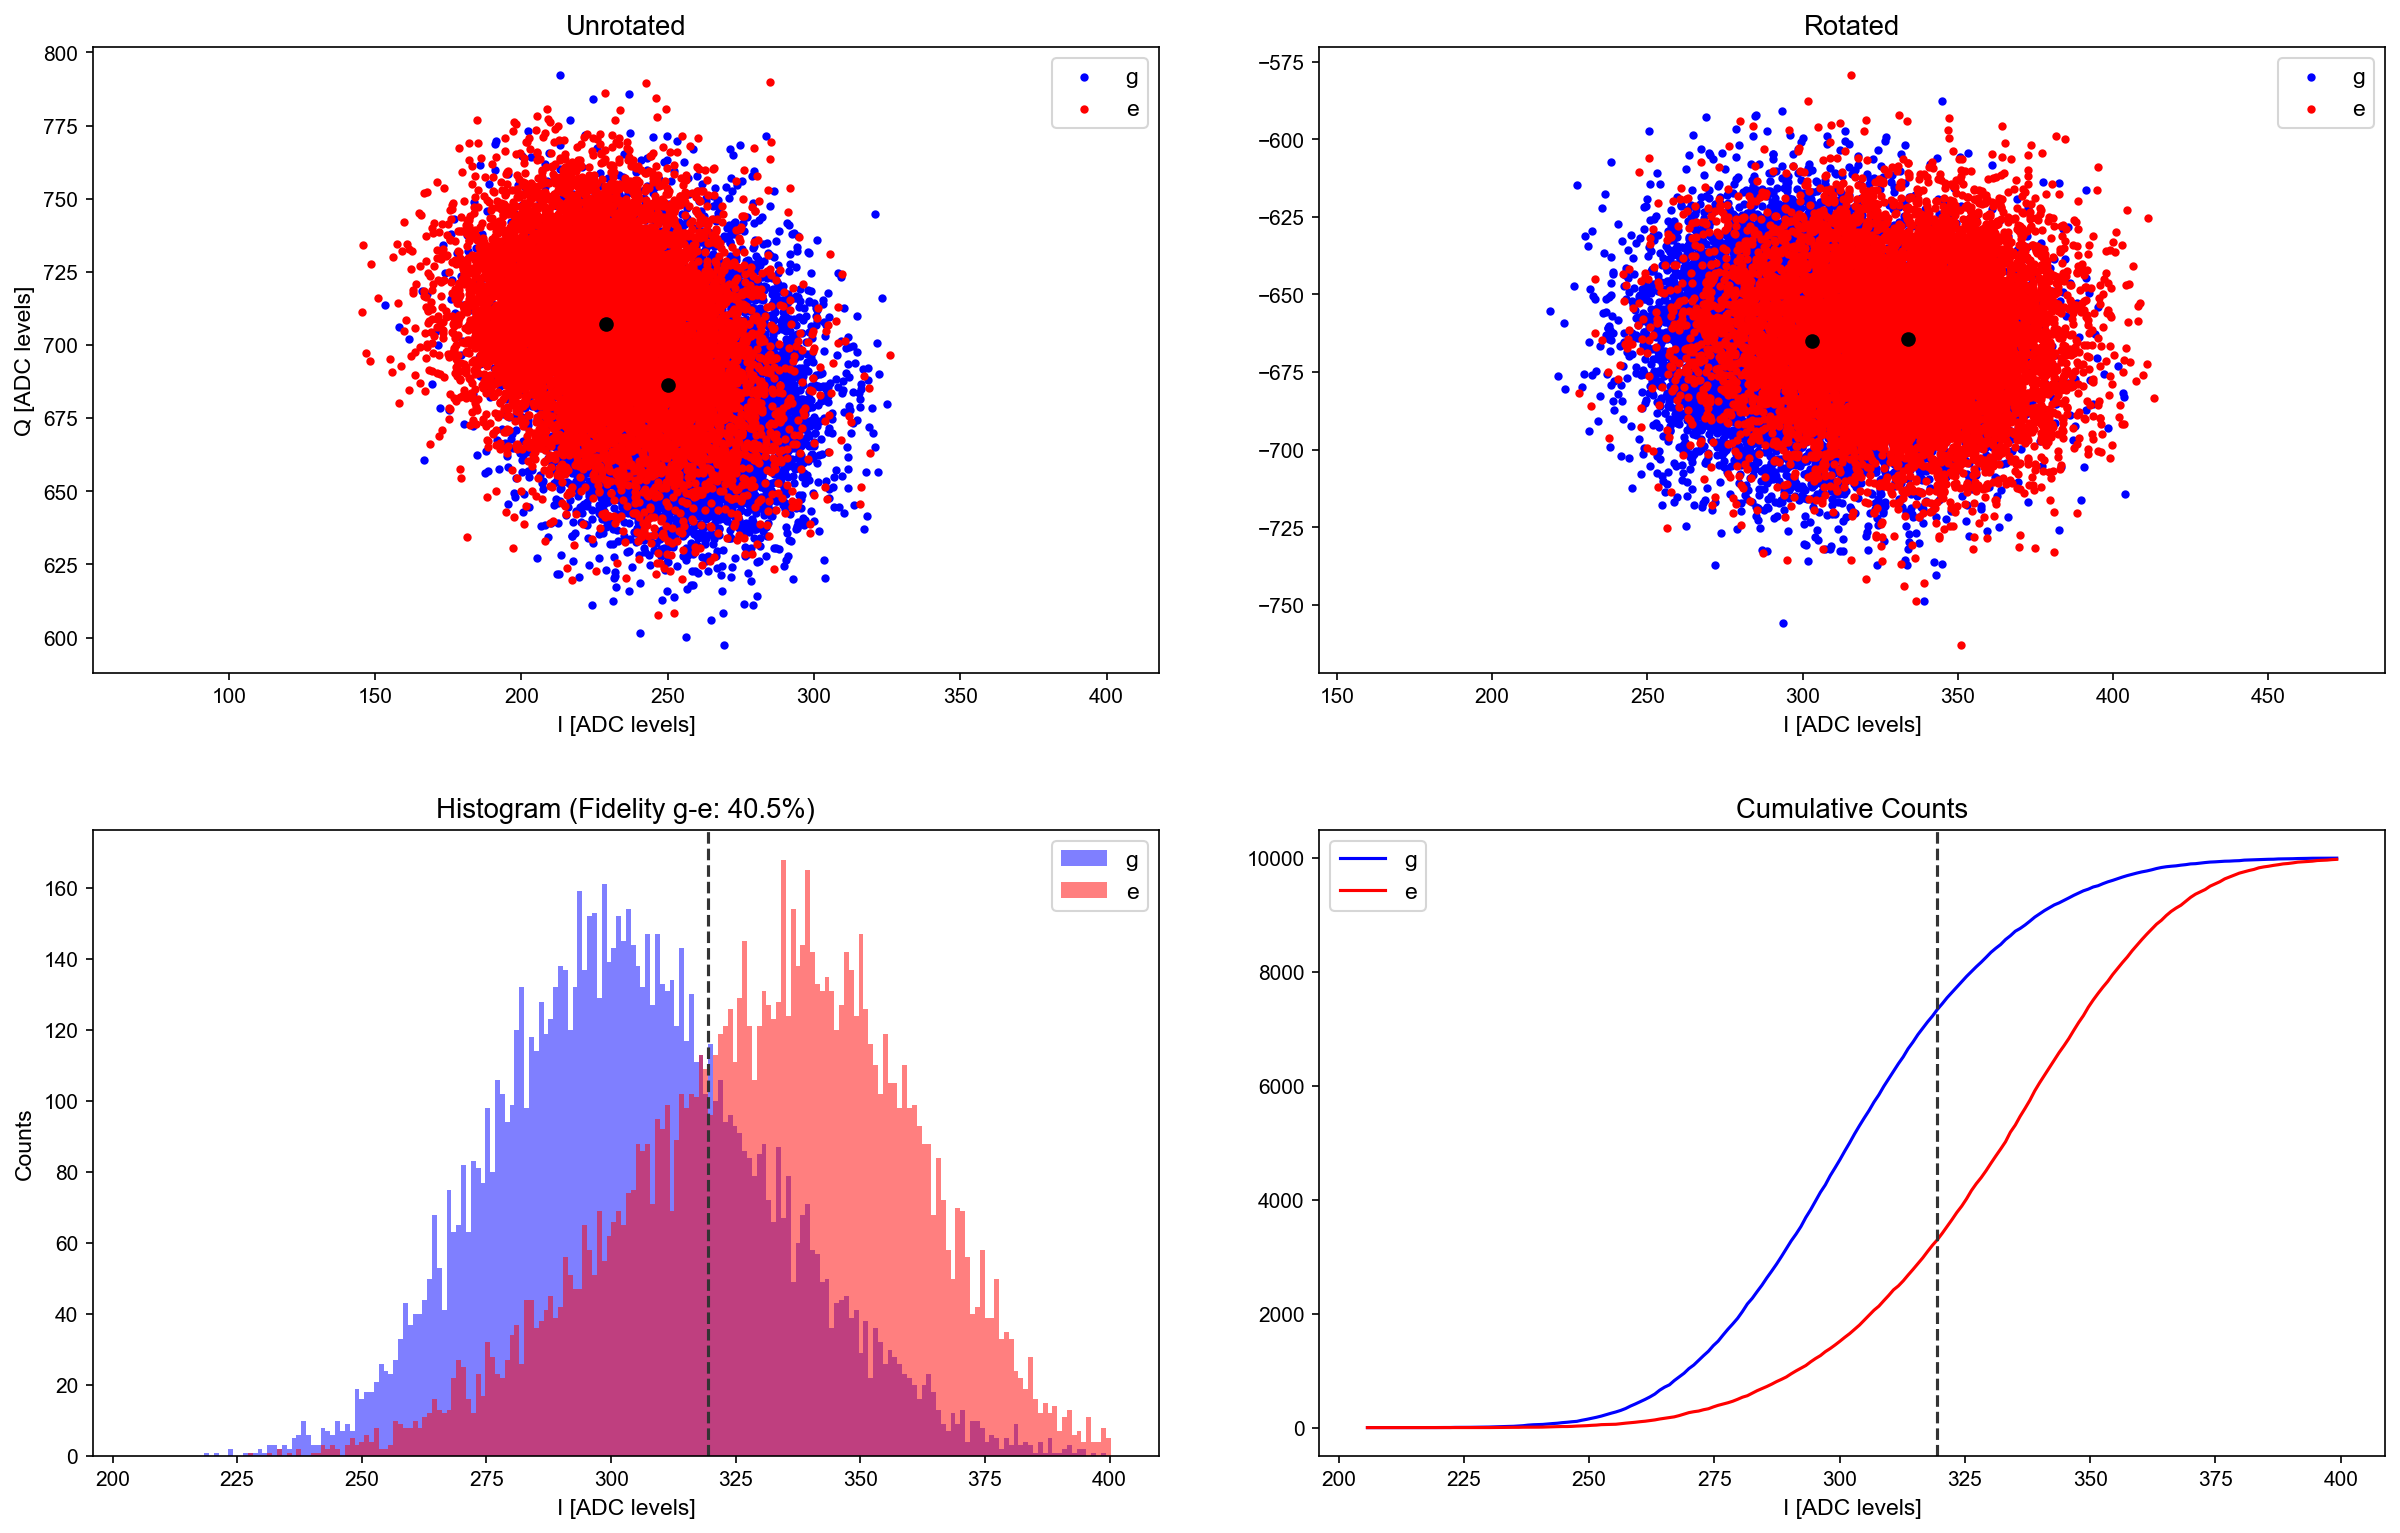

Qubit  (1)


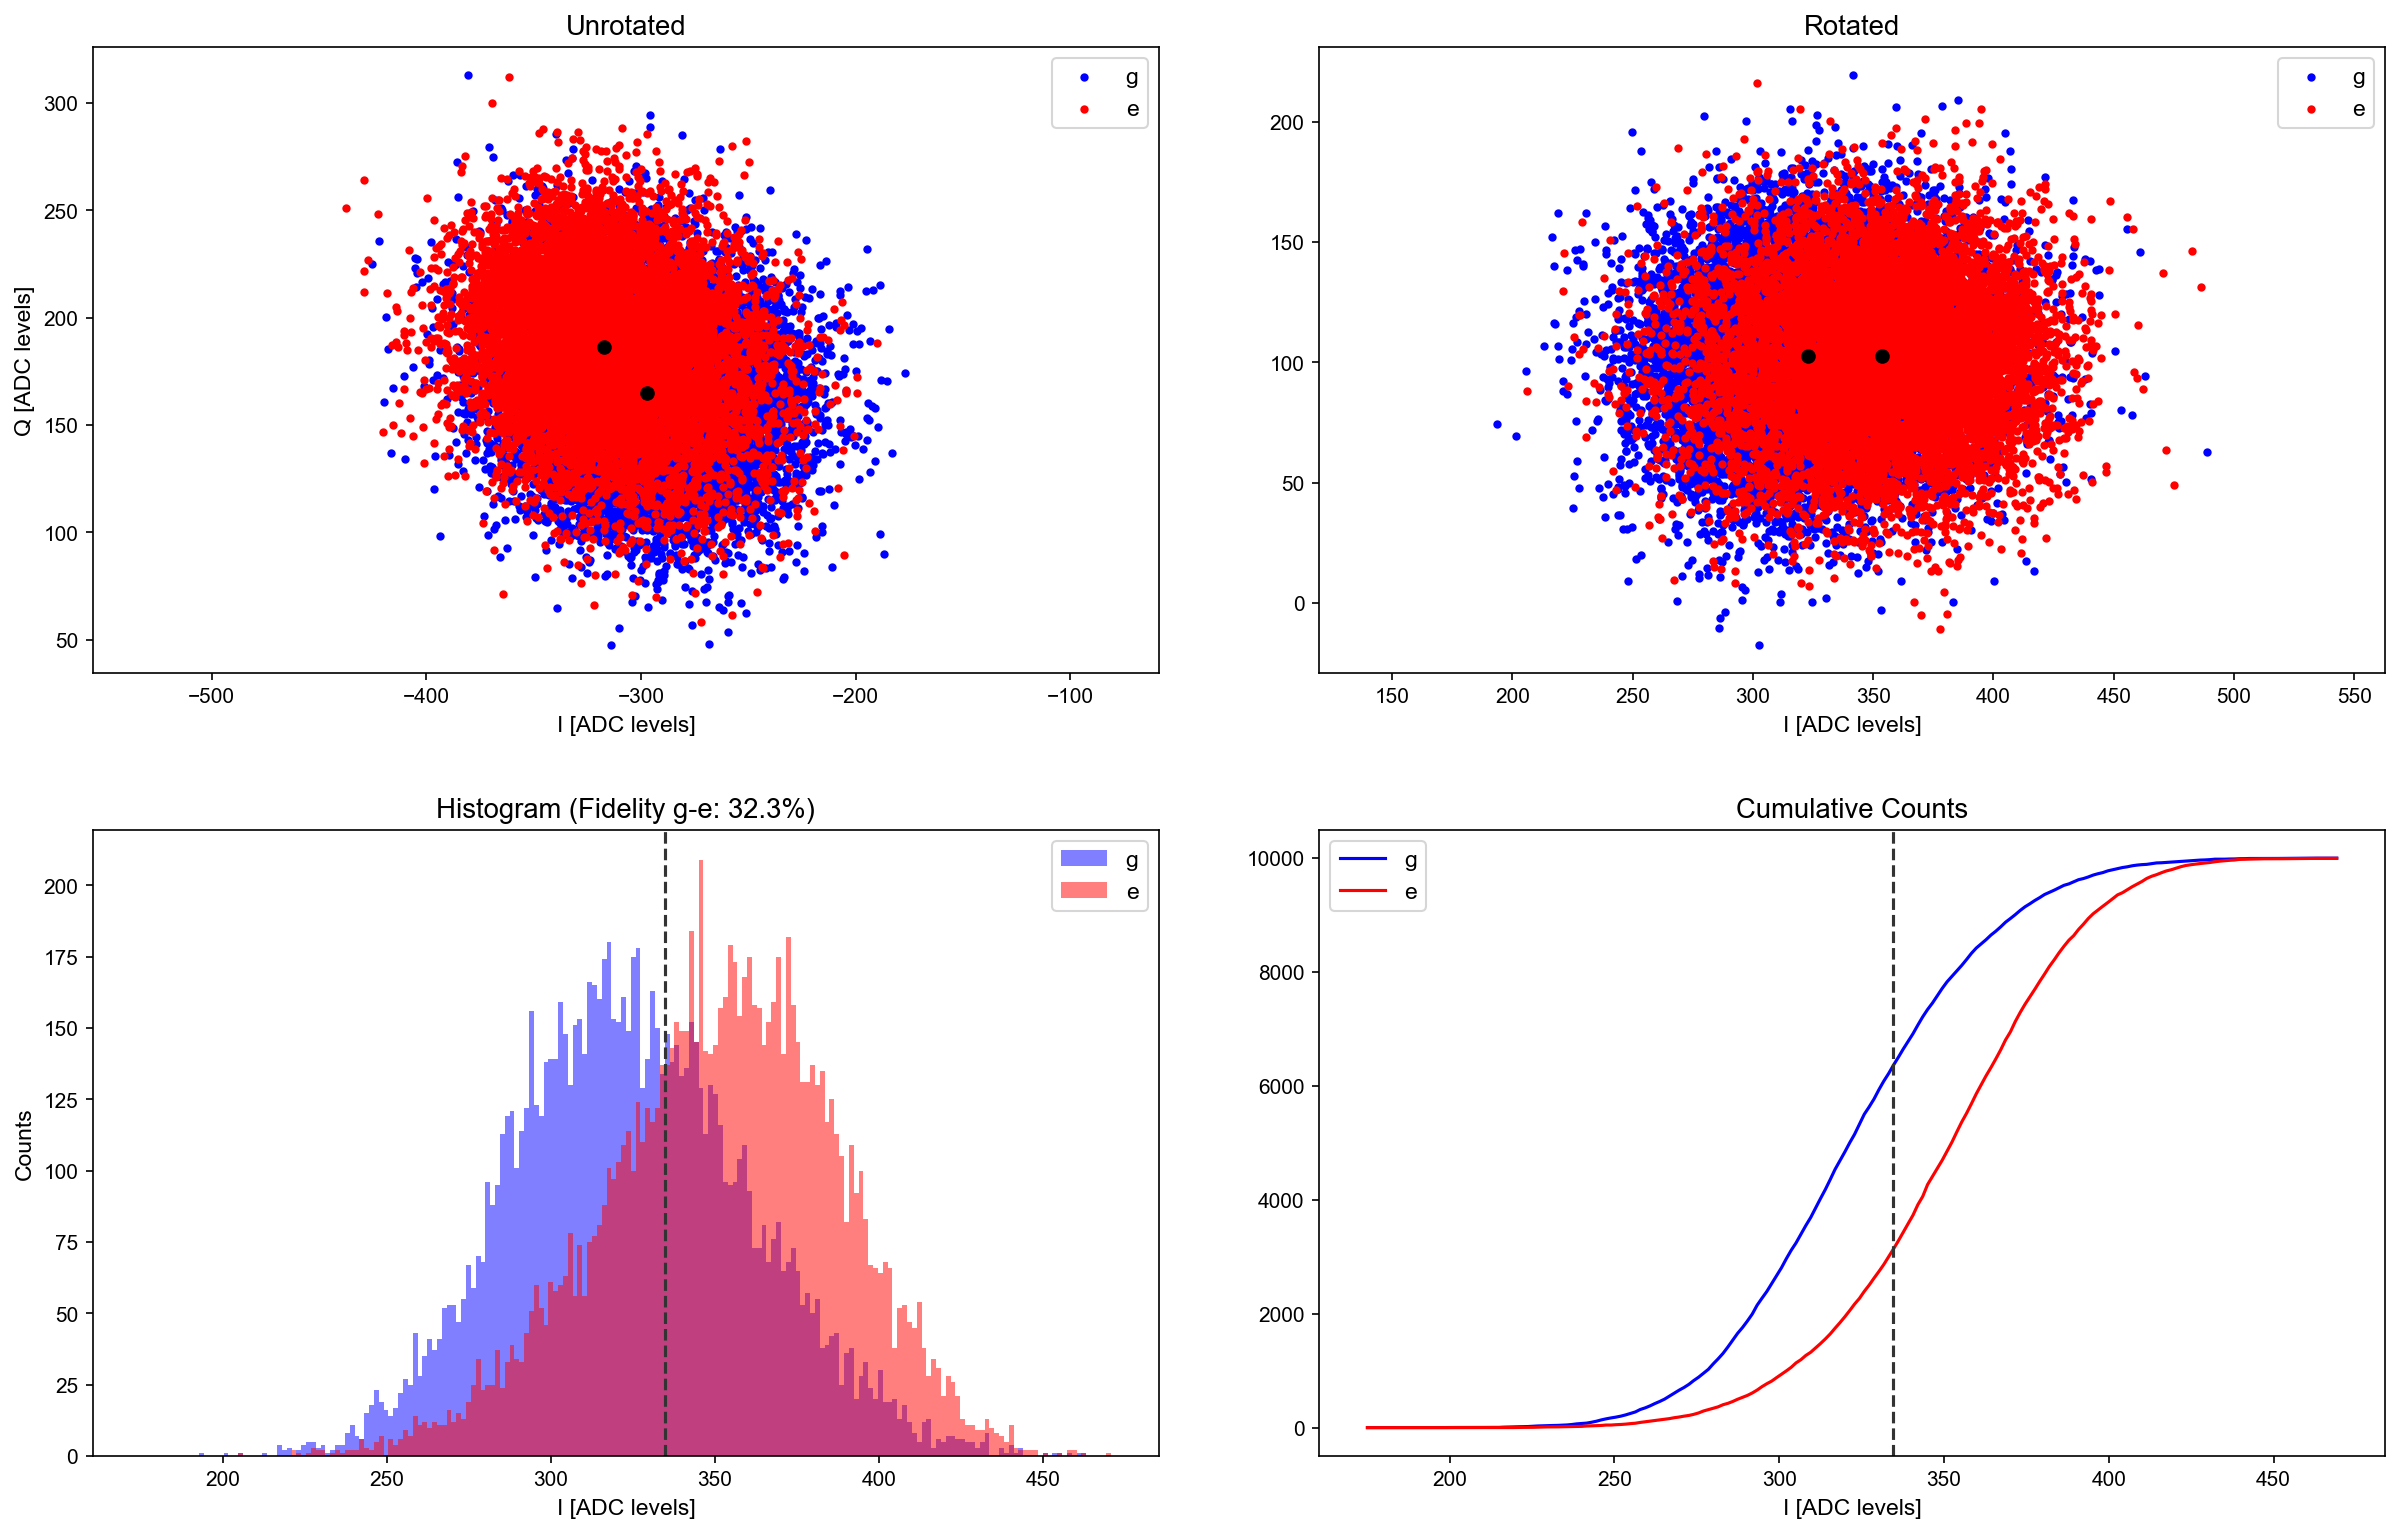

thresholds [0, 334.6632877453909, 319.4942239958658, 0]
angles [0, -133.28396174359904, -135.45477721706672, 0]
[-9.67881548974943, 322.8412303054573, 302.9673601314405, -253.36739342661895]
[-14.102993817116824, 353.77602729313486, 303.16701872750696, -284.71461112918973]
[-11.321998047510576, 320.26262536213903, 333.98353446633746, -255.75170842824602]
[-13.732346241457858, 353.1897099981565, 333.77370911131396, -277.63520989261303]


  0%|          | 0/9 [00:00<?, ?it/s]

[-12.540351448096324, 318.06358517750357, 318.41772688531546, -281.5361210543443]
[-11.525707777416205, 339.28965414250115, 318.4977737570134, -262.5320533680442]
[-12.14480963228116, 338.16702648561017, 318.985319501308, -269.82378782948257]
[-11.874715261958997, 317.9667815872567, 301.808423506286, -276.59794988610474]
[-10.974454930035796, 340.5095346651243, 302.95031824671923, -259.8273673934266]
[-13.606085258704848, 337.49345699000696, 305.462690844979, -284.0758216726326]
[-10.43475431174748, 324.6691212880934, 310.4843503726832, -254.90026033192322]
[-13.837780670354704, 335.5659494788446, 306.4916708657329, -288.3699967458509]
[-11.57598438008461, 341.0453310081483, 306.33990915305606, -258.36609176700296]


In [345]:
tomo = meas.EgGfStateTomographyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"EgGf_state_tomo_{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

tomo.cfg.expt = dict(
    reps=10000, # reps per measurement basis
    qubits=qubits,
)

print(tomo.cfg)
tomo.go(analyze=False, display=False, progress=True, save=False)

### Qram experiment

In [ ]:
qramExpt = meas.QramProtocolExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

span = 2.0 # total time [us]
npts = 200
print('time step size [cycles]:', soc.us2cycles(span/npts))

qramExpt.cfg.expt = dict(
    start=0, # start protocol time [us],
    step=span/npts, # time step [us], 
    expts=npts, # number of different time experiments, 
    reps=5000, # number of reps per time step,
    tomo_2q=True, # True/False whether to do 2q state tomography on state at last time step
    tomo_qubits=[0,1], # the qubits on which to do the 2q state tomo
    singleshot_reps=10000, # reps per state for singleshot calibration
    post_process='threshold' # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None
    # thresholds=[48.765112894093534, 96.26256512031452, 332.5698328167488, 907.1402810621812],
    # ge_avgs=None, # (optional) don't rerun singleshot and instead use this
    # angles=[54.85719696454403, -4.061056979857183, 77.35730820785261, -80.28753842272687]
)

# qramExpt.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]

# print(qramExpt.cfg)

qramExpt.go(analyze=False, display=False, progress=True, save=False)

time step size [cycles]: 3
thresholds=[48.765112894093534, 96.26256512031452, 332.5698328167488, 907.1402810621812]
angles=[54.85719696454403, -4.061056979857183, 77.35730820785261, -80.28753842272687]


  0%|          | 0/200 [00:00<?, ?it/s]

end times [0.396, 0.4656, 0.6976, 1.0936, 1.1576, 1.4476, 1.5146]


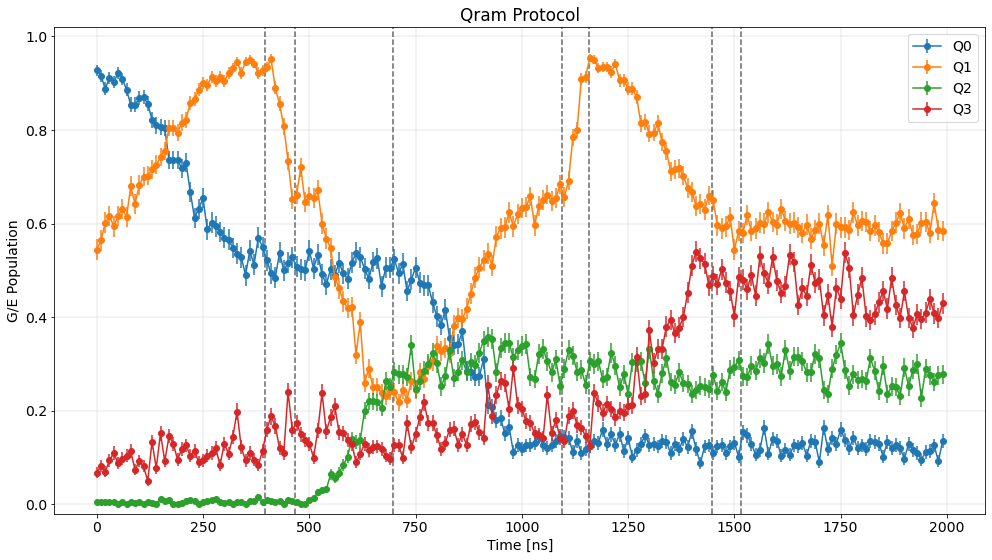

In [ ]:
qramExpt.analyze()
qramExpt.display()

## Run analysis

In [346]:
tomo = tomo
# tomo = qramExpt

# data, attrs = prev_data(expt_path, '00000_EgGf_state_tomo_01.h5')
# pulse_dict = attrs['pulse_dict']
# assert np.all(np.array(attrs['meas_order']) == meas_order)
# assert np.all(np.array(attrs['calib_order']) == calib_order)

data = tomo.data
pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == meas_order)
assert np.all(np.array(tomo.calib_order) == calib_order)

n_tomo = np.array(data['counts_tomo'])
n_calib = np.array(data['counts_calib'])

print('Tomography counts')
print(n_tomo)
print('Confusion matrix counts')
print(n_calib)
print('Corrected tomo matrix will be')
print(correct_readout_err(n_tomo, n_calib))

Tomography counts
[[3525 1593 3208 1674]
 [2419 2679 2181 2721]
 [2433 2638 2211 2718]
 [4993 2176 1711 1120]
 [3241 3753 1208 1798]
 [3348 3397 1395 1860]
 [3946 2146 2127 1781]
 [3383 3199 1548 1870]
 [3028 3494 1421 2057]]
Confusion matrix counts
[[4787 2437 1430 1346]
 [2148 5056  852 1944]
 [2065 1136 4510 2289]
 [1116 1980 2081 4823]]
Corrected tomo matrix will be
[[ 5182.58765  -434.19535  5809.07307  -557.46537]
 [ 2227.62424  2575.85311  2312.02423  2884.49842]
 [ 2279.64216  2455.89471  2388.77795  2875.68518]
 [10499.44682  -660.2157    956.66315  -795.89426]
 [ 4289.12533  5174.35974   173.53179   362.98315]
 [ 4816.51799  4029.77695   505.61922   648.08584]
 [ 7138.72984    65.01748  2135.5371    660.71558]
 [ 4969.15504  3469.70763   893.03854   668.09879]
 [ 3786.65505  4519.79245   584.57693  1108.97557]]


Generate test data

In [390]:
n_tomo = generate_counts(qubits=qubits, rho_id=rho_id, n_tot=1000, noise=1)
# print(n_tomo)

Calculate ideal psi for fidelity calculation. Change this depending on what you want for ideal final state.

In [263]:
psi_id = qt.tensor(1/np.sqrt(2)*(psiZ[0]+psiZ[1]), psiZ[0])
# psi_id = qt.tensor(psiZ[1], psiZ[1])
# psi_id = qt.tensor(psiZ[0], psiZ[1])

rho_id = qt.ket2dm(psi_id)
print(rho_id)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.5 0.  0.5 0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.5 0. ]
 [0.  0.  0.  0. ]]


##### Run MLE without ZZ correction

In [347]:
# methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
rho_MLE_base = run_MLE(n=correct_readout_err(n_tomo, n_calib), ZZ_correction=False, method='L-BFGS-B')
if rho_MLE_base is not None:
    fid_base = qt.fidelity(qt.Qobj(rho_MLE_base, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_base = np.real(np.trace(rho_MLE_base @ rho_MLE_base))
    print(f'Fidelity (no ZZ correction): {fid_base}')
    print(f'Purity (no ZZ correction): {purity_base}')

 <ipython-input-121-6a6b3d84e3f8>: 10ComplexWarning: Casting complex values to real discards the imaginary part
 <ipython-input-121-6a6b3d84e3f8>: 14

Convergence: True
Fidelity (no ZZ correction): 0.8247934090891778
Purity (no ZZ correction): 0.8355488827221799


In [348]:
print(np.around(rho_MLE_base, decimals=3))

[[ 0.438+0.j    -0.002+0.014j  0.368-0.266j -0.002-0.005j]
 [-0.002-0.014j  0.038+0.j    -0.007-0.01j   0.001+0.009j]
 [ 0.368+0.266j -0.007+0.01j   0.474+0.j    -0.002+0.005j]
 [-0.002+0.005j  0.001-0.009j -0.002-0.005j  0.05 +0.j   ]]


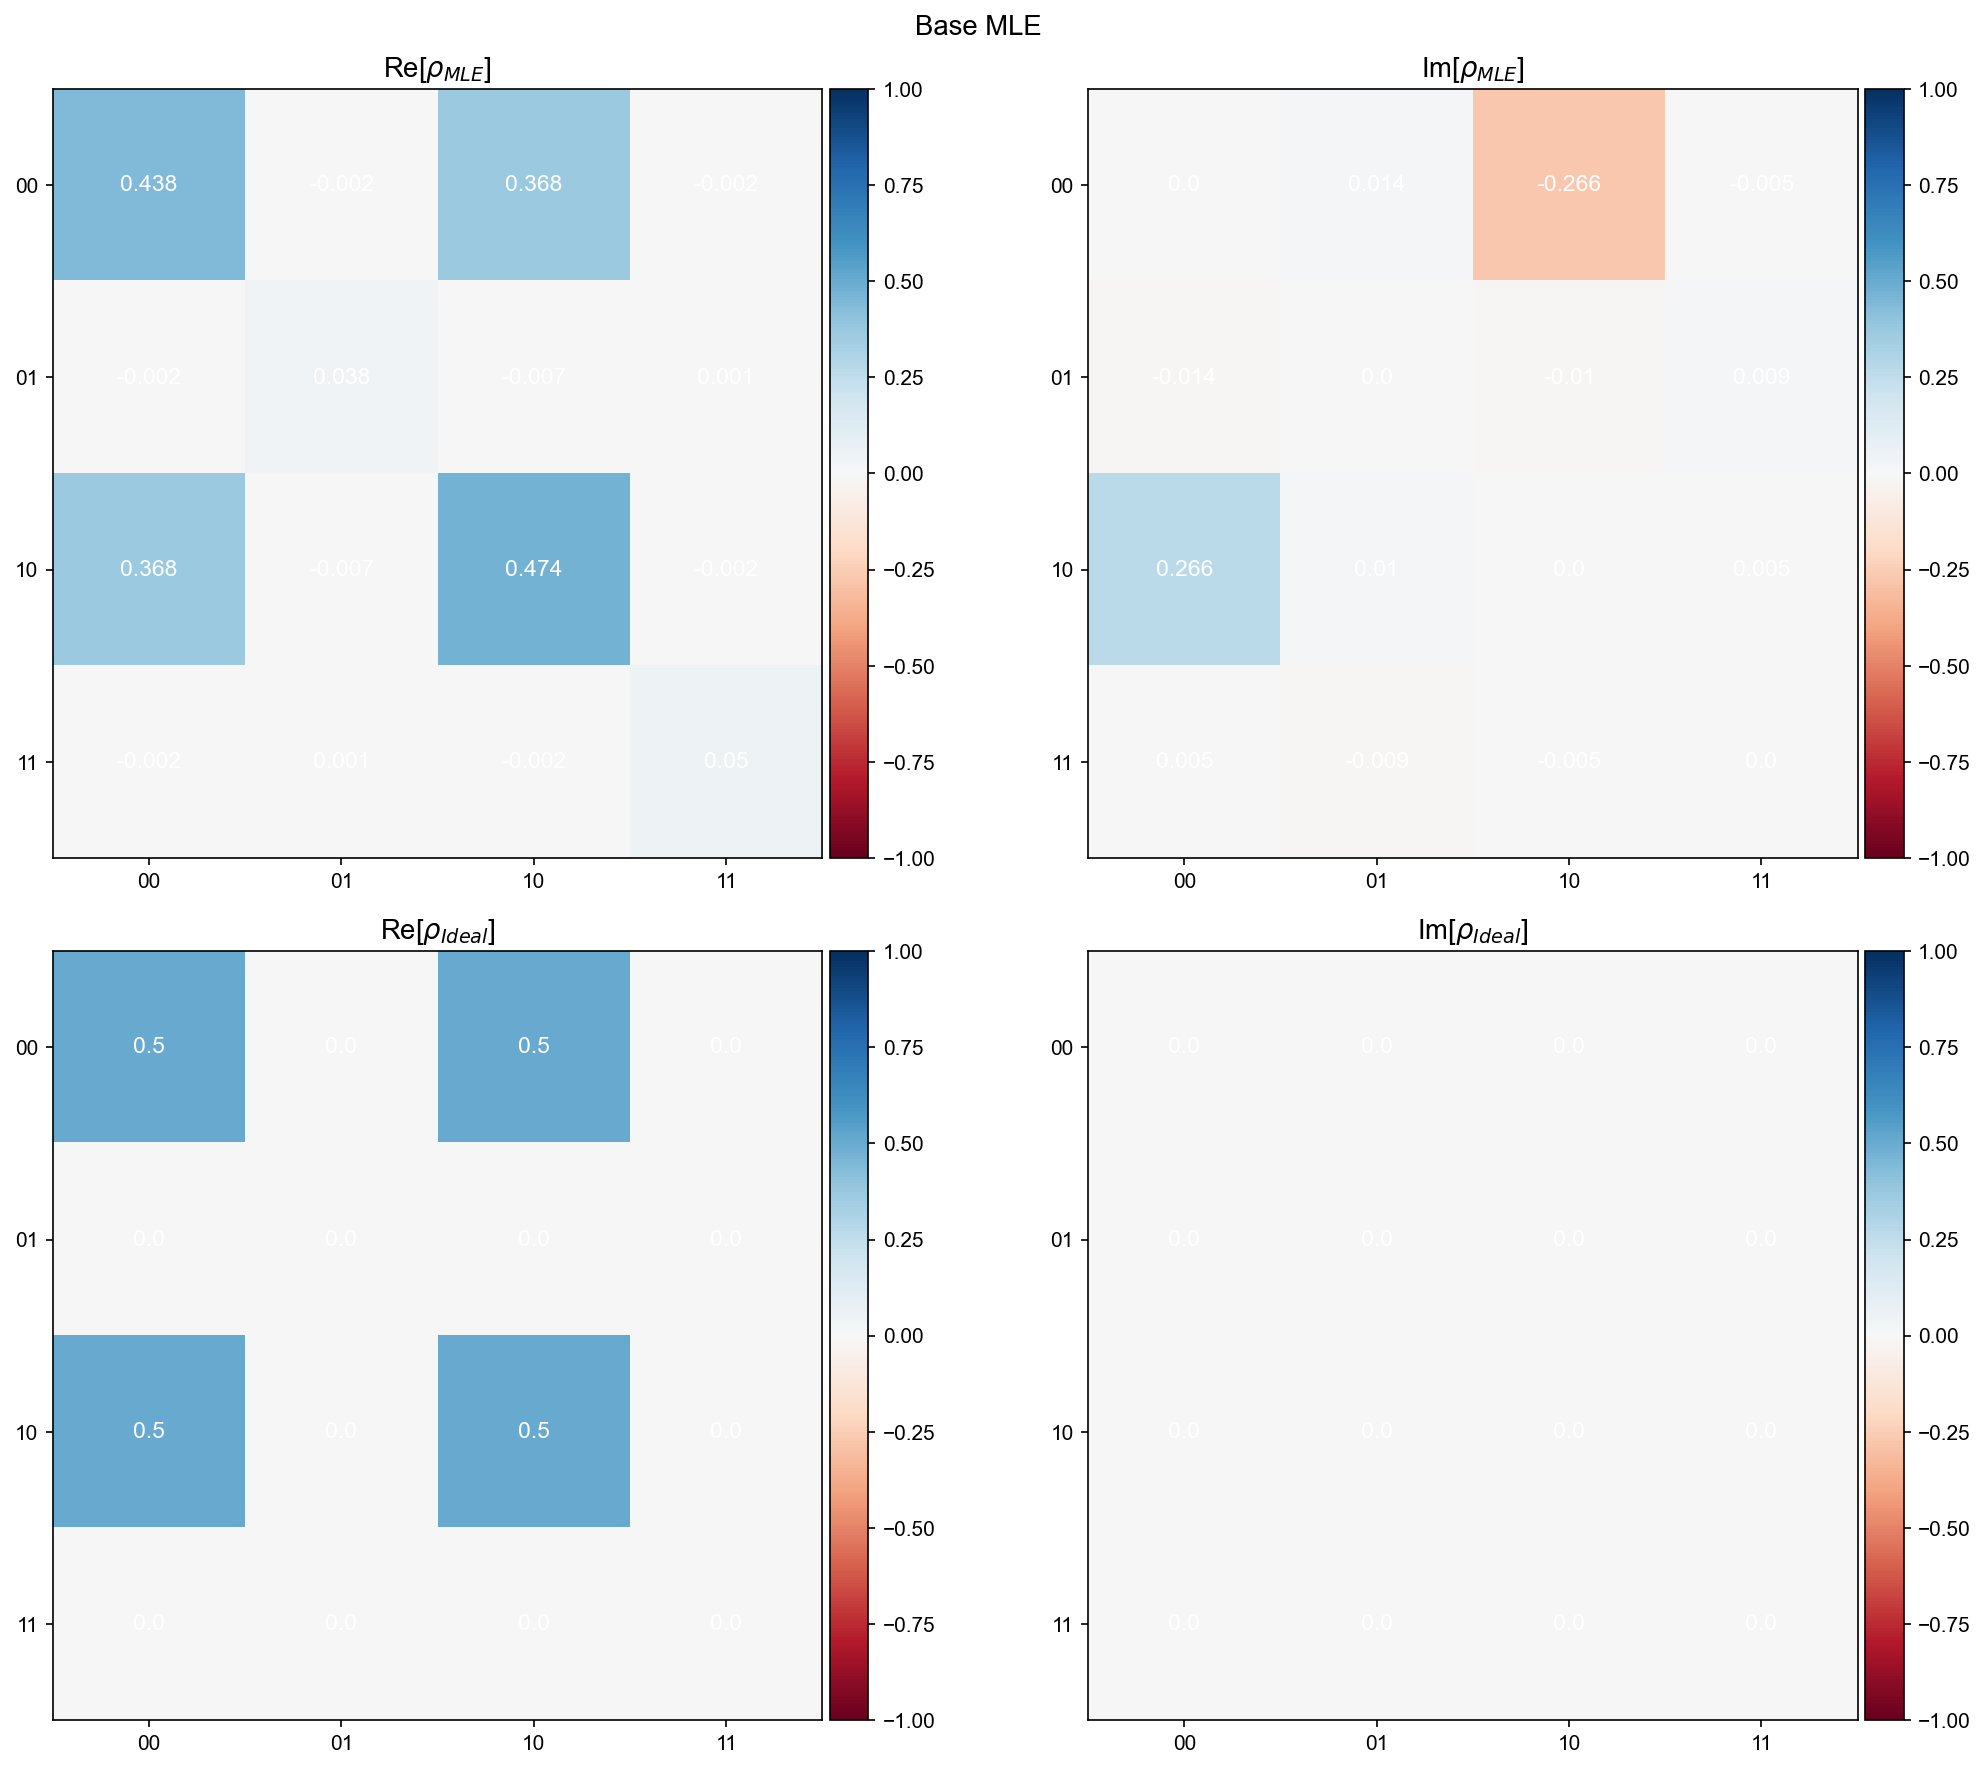

In [349]:
show_plot_rho_2d(rho_MLE_base, rho_id, title='Base MLE')

#### Run MLE with ZZ

Get evoln matrices for ZZ

In [330]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [387]:
f_ge = np.array([f + (4000 if f < 1000 else 0) for f in yaml_cfg.device.qubit.f_ge]) # MHz
f_ef = np.array([f + (4000 if f < 1000 else 0) for f in yaml_cfg.device.qubit.f_ef]) # Mhz
# gs = np.array([51, 51, 36, 9, 8, 3.5]) # MHz

q0, q1 = qubits
ZZs_4q = np.reshape(np.array(yaml_cfg.device.qubit.ZZs), (4,4)) # MHz
f_ge = np.array([f_ge[q0], f_ge[q1]])
f_ef = np.array([f_ef[q0], f_ef[q1]])
alphas = f_ef - f_ge # MHz
ZZs = np.array([[0., 0.], [0., 0.]])
ZZs = np.array([[100., 100.], [100., 100.]])
# ZZs[0, 1] = ZZs_4q[q0, q1]
# ZZs[1, 0] = ZZs_4q[q1, q0]

print('qubit freqs', f_ge)
print('alphas', alphas)
print('ZZs', ZZs)
# print(pulse_dict)

evol_matrices = get_evoln_mats(qubits=qubits, qfreqs=f_ge*1e-3, ZZs=ZZs*1e-3, pulse_dict=pulse_dict)
# evol_matrices = get_evoln_mats(qubits=qubits, qfreqs=f_ge*1e-3, alphas=alphas*1e-3, gs=gs*1e-3, pulse_dict=pulse_dict)

qubit freqs [4145.57203495 3464.7274884 ]
alphas [-224.47579811 -100.4744884 ]
ZZs [[100. 100.]
 [100. 100.]]


 56%|█████▌    | 5/9 [00:00<00:00, 45.87it/s]

all pulse_cfgs for basis ZZ {'measure': {'ch': 6, 'name': 'measure', 'type': 'mux4', 'mask': [0, 1, 2, 3], 'length': 4301, 'flag': None}, 'X_q2': {'ch': 0, 'name': 'X_q2', 'type': 'gauss', 'sigma': 17, 'freq_MHz': 145.572034953271, 'phase_deg': 0, 'gain': 24653, 'flag': None}, 'X_q1': {'ch': 5, 'name': 'X_q1', 'type': 'gauss', 'sigma': 11, 'freq_MHz': 3464.727488396267, 'phase_deg': 0, 'gain': 22147, 'flag': None}, 'ef_qubit1': {'ch': 5, 'name': 'ef_qubit1', 'type': 'gauss', 'sigma': 15, 'freq_MHz': 3364.253, 'phase_deg': 0, 'gain': 13553, 'flag': None}, 'pi_EgGf_21': {'ch': 4, 'name': 'pi_EgGf_21', 'type': 'const', 'length': 136, 'freq_MHz': 2678.7, 'phase_deg': 0, 'gain': 2679, 'flag': None}, 'Xhalf_q2': {'ch': 0, 'name': 'Xhalf_q2', 'type': 'gauss', 'sigma': 17, 'freq_MHz': 145.572034953271, 'phase_deg': 0, 'gain': 12326, 'flag': None}}
total length 0
basis ZZ overlap (1+0j)
[] (GHz)
[] (ns)
total pulse length 0.0 ns
all pulse_cfgs for basis ZX {'measure': {'ch': 6, 'name': 'measure

100%|██████████| 9/9 [00:00<00:00, 44.12it/s]


(array([ 0.31415927, 21.45536558, 25.73323803, 48.13108141]), array([Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[1.]
        [0.]
        [0.]
        [0.]]                                                             ,
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[0.]
        [1.]
        [0.]
        [0.]]                                                             ,
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[0.]
        [0.]
        [1.]
        [0.]]                                                             ,
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[0.]
        [0.]
        [0.]
        [1.]]                                                             ],
      dtype=object))
Xhalf_q1
18.362713675213676 0.038507749654726316
21.141206317754694
(array([ 0.

In [370]:
rho_MLE_ZZ = run_MLE(n=correct_readout_err(n_tomo, n_calib), rho_guess=None, ZZ_correction=True, evol_matrices=evol_matrices)
fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
print(f'Fidelity (with ZZ correction): {fid_ZZ}')
print(f'Purity (with ZZ correction): {purity_ZZ}')

 <ipython-input-121-6a6b3d84e3f8>: 10ComplexWarning: Casting complex values to real discards the imaginary part
 <ipython-input-121-6a6b3d84e3f8>: 14

Convergence: True
Fidelity (with ZZ correction): 0.41205876719751444
Purity (with ZZ correction): 0.45891842990045006


In [371]:
print(np.around(rho_MLE_ZZ, decimals=3))

[[ 0.346+0.j    -0.008+0.212j  0.   +0.j     0.   +0.j   ]
 [-0.008-0.212j  0.13 +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.478+0.j    -0.029+0.j   ]
 [ 0.   +0.j     0.   +0.j    -0.029+0.j     0.046+0.j   ]]


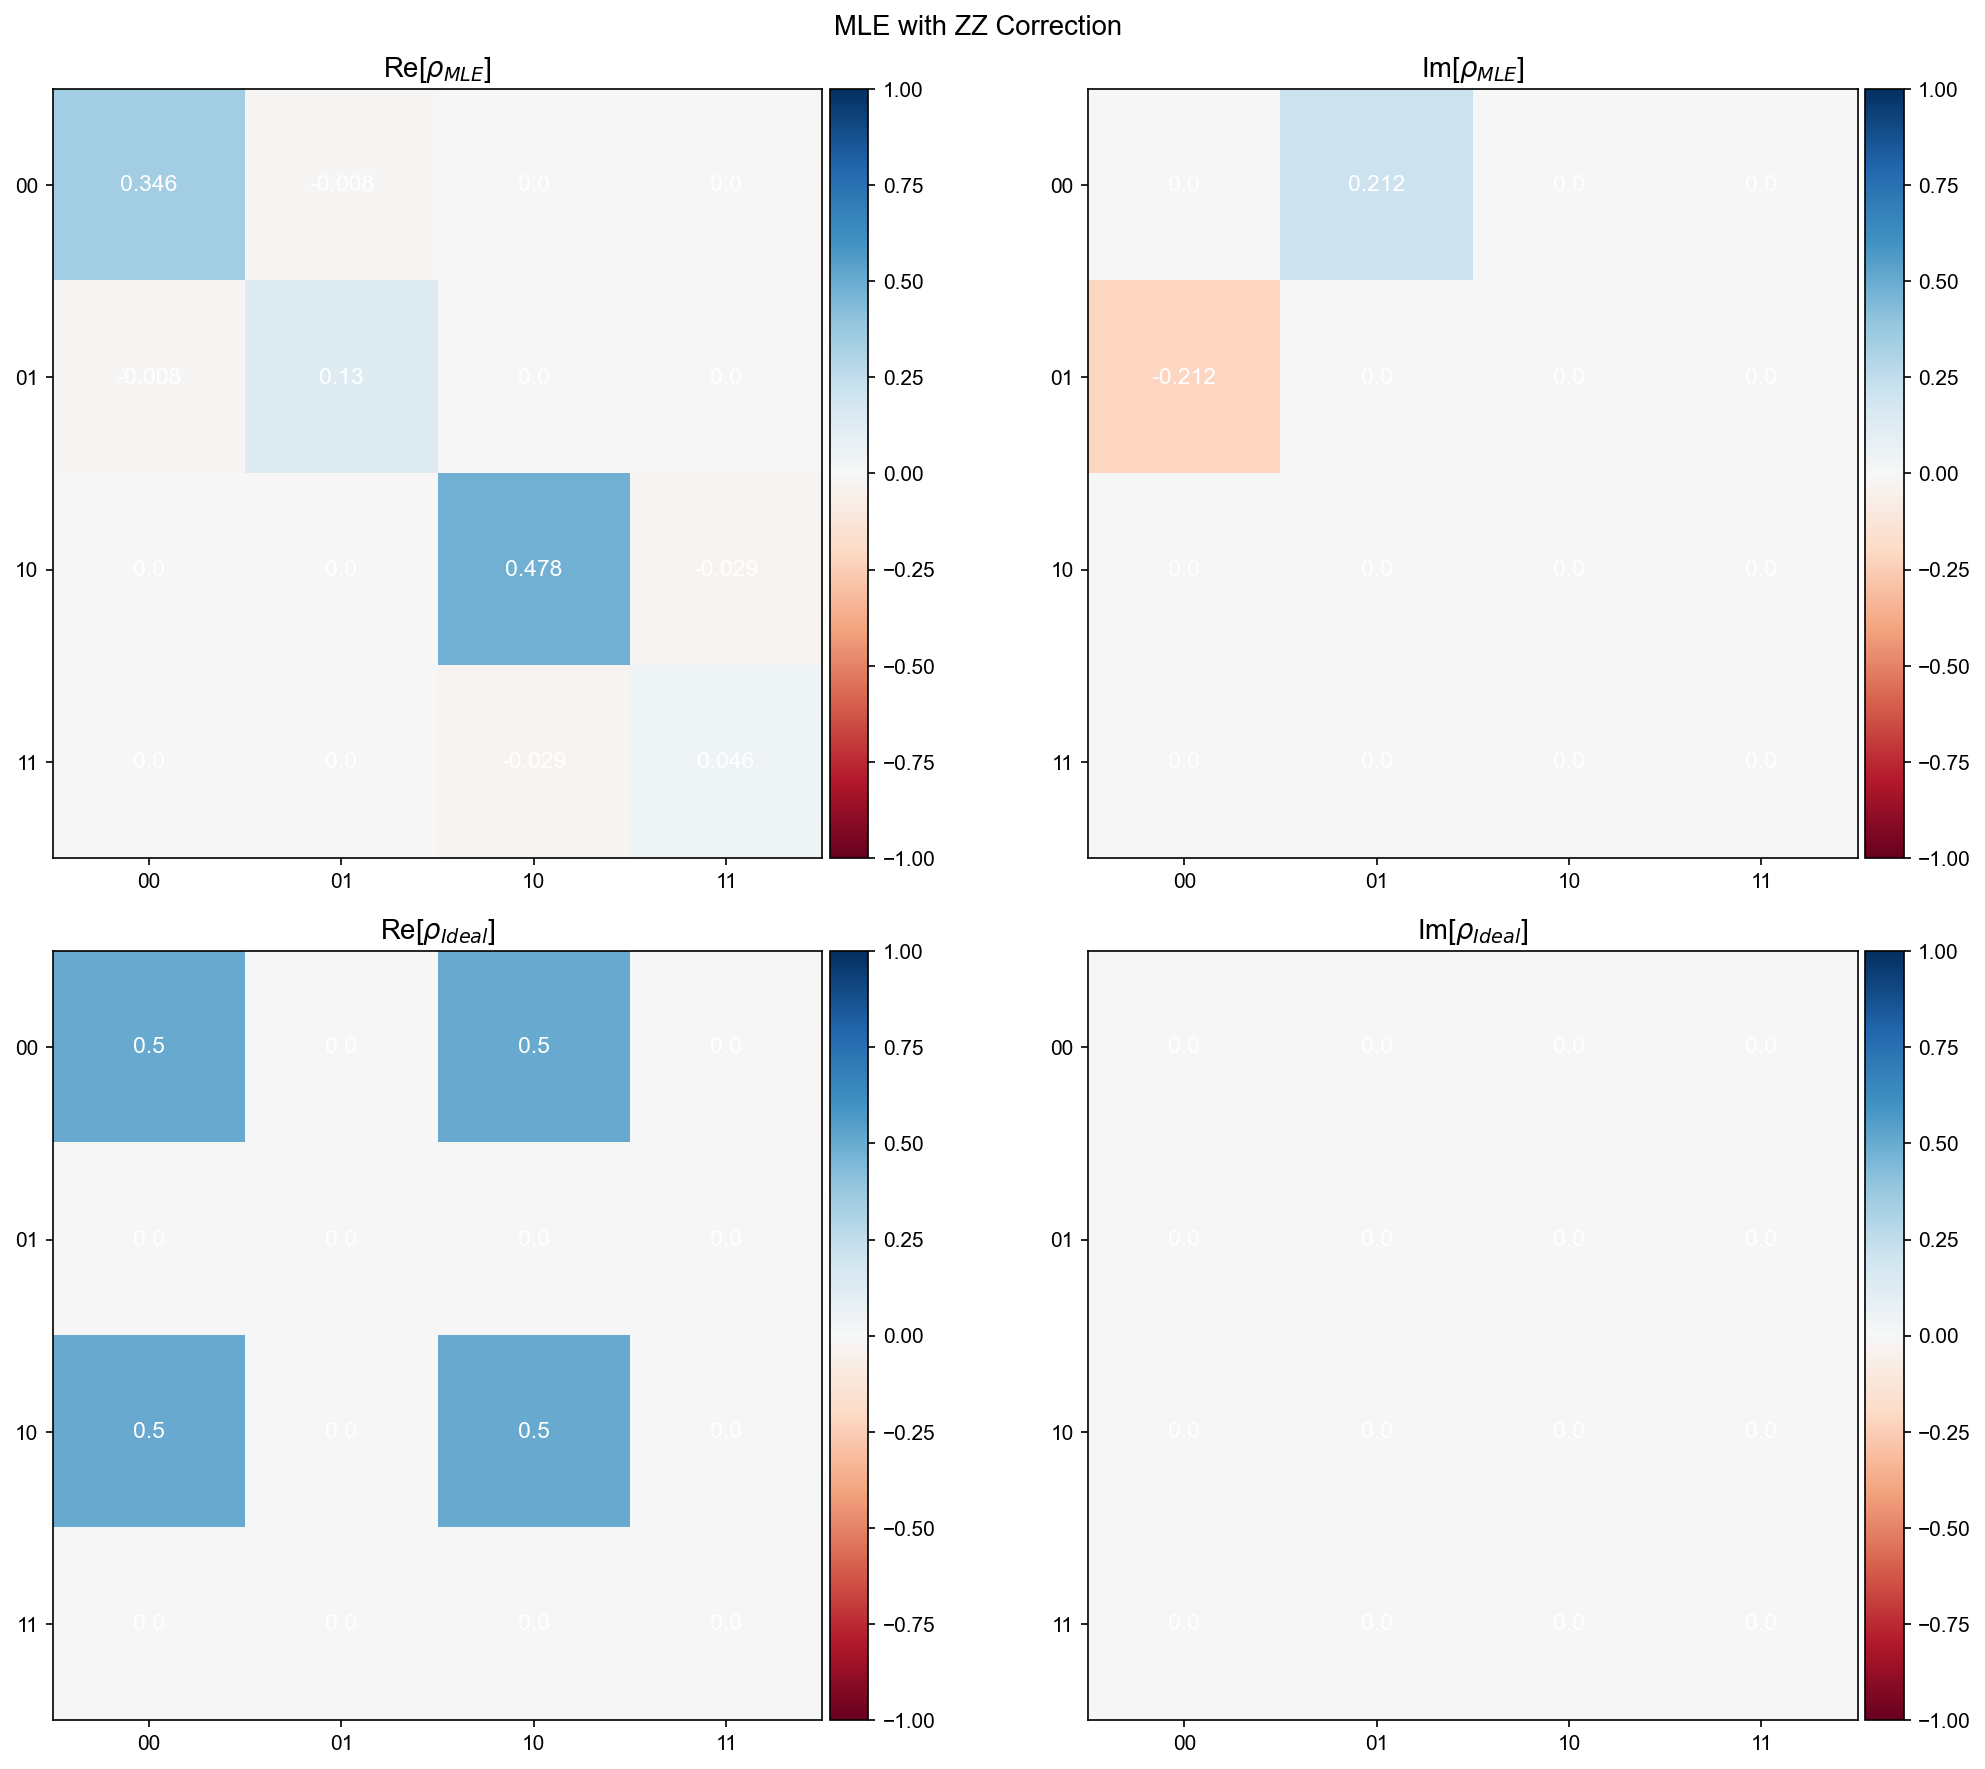

In [372]:
show_plot_rho_2d(rho_MLE_ZZ, rho_id, title='MLE with ZZ Correction')

In [84]:
tomo.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00001_EgGf_state_tomo_01.h5
